# Covariate Analysis (Separate Managed Areas)

This document includes Python codes that conduct correlation analysis between water quality parameters and water depth, and LDI.

The analysis is conducted in Charlotte Harbor, Estero Bay and Big Bend

* [1.Data Preprocess](#preprocessing)
    * [1.1 Preset Parameters](#preset)
    * [1.2 Combine Con and Dis data](#combine)
    * [1.3 Select Parameters and Areas](#select)
    
* [2. Extract Raster Value to Point](#extract_raster_value_to_points)
* [3. Regression Analysis](#reg_result)
* [4. Regression Result](#reg_result_ch)
    * [4.1 Charlotte Harbor](#reg_result_ch)
        * [4.1.1 Water Depth](#reg_result_ch_wd)
        * [4.1.2 Land Development Index](#reg_result_ch_ldi_huc_lss)
    * [4.2 Estero Bay](#reg_result_eb)
        * [4.2.1 Water Depth](#reg_result_eb_wd)
        * [4.2.2 Land Development Index](#reg_result_eb_ldi)
    * [4.2 Big Bend](#reg_result_bb)
        * [4.3.1 Water Depth](#reg_result_bb_wd)
        * [4.3.2 Land Development Index](#reg_result_bb_ldi)

In [150]:
import geopandas as gpd
import rasterio as rio
from scipy.stats import pearsonr
import statsmodels.api as sm
import pandas as pd
import numpy as np
import os
import re
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='once')

# 1. Data Preprocessing <a class="anchor" id="preprocessing"></a>
Define the water depth, water quality parameter, and LDI folders

In [151]:
# path = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/'
# path_gis = '/Users/cong/Downloads/WaterQualityProject/SEACAR_WQ_Pilot-selected/GIS_data/'
#WQ_path = path_gis+'WQPara/'

path = 'E:/Projects/SEACAR_WQ_Pilot/'
path_gis = 'E:/Projects/SEACAR_WQ_Pilot/GIS_data/'
WQ_path = path+'Correlation_Analysis/WQPara/'

# Define the water depth, water quality parameter, and LDI folders
path_LDI = path_gis+'covariates/ldi/'
# WaterDepth = path_gis + 'NCEI_DEM_30m.tif'
WaterDepth = path_gis + 'covariates/NCEI_DEM_30m.tif'
LDI_HUC_LSS = path_LDI + 'LDI_HUC12River_LogScaleSUM.tif'
LDI_HUC_Median = path_LDI +'LDI_HUC12River_Median.tif'
LDI_WHO_LSS = path_LDI + 'LDI_WholeRiver_LogScaleSUM.tif'
LDI_WHO_Median = path_LDI + 'LDI_WholeRiver_Median.tif'

In [152]:
dfDis_orig = pd.read_csv(path + r"discrete_0214.csv")
dfCon_orig = pd.read_csv(path + r"continuous_0214.csv")

C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\156691913.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dfDis_orig = pd.read_csv(path + r"discrete_0214.csv")


# 1.1 Preset function parameters <a class="anchor" id="preset"></a>


In [153]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]

dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte_Harbor','Big Bend Seagrasses Aquatic Preserve':'Big_Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM_Reserve','Estero Bay Aquatic Preserve':'Estero_Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne_Bay','Matlacha Pass Aquatic Preserve':'Matlacha_Pass_AP',
                'Lemon Bay Aquatic Preserve':'Lemon_Bay','Cape Haze Aquatic Preserve':'Cape_Haze_AP','Pine Island Sound Aquatic Preserve':'Pine_Island'}
dictUnits   = {'Salinity':'ppt','Total Nitrogen': 'mg/L','Dissolved Oxygen': 'mg/L','Turbidity': 'NTU', 'Secchi Depth': 'm'}
listArea    = dfCon_orig["ManagedAreaName"].unique()
dictPara = {'Salinity':'SA', 'Total Nitrogen': 'TN', 'Dissolved Oxygen': 'DO', 'Turbidity': 'TUR', 'Secchi Depth': 'SD'} 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]

# Interested areas
areas = ['Gasparilla Sound-Charlotte Harbor Aquatic Preserve', 'Big Bend Seagrasses Aquatic Preserve', 'Estero Bay Aquatic Preserve']
# Interested parameters
parameters = ['Salinity','Total Nitrogen','Dissolved Oxygen']
SpatialRef = '3086'

# dry season period
dry_start_16, dry_end_17 = '11/01/2016', '04/30/2017'
dry_start_17, dry_end_18 = '11/01/2017', '04/30/2018'

# wet season period
wet_start_17, wet_end_17 = '05/01/2017', '10/31/2017'
wet_start_18, wet_end_18 = '05/01/2018', '10/31/2018'

# time periods of the dry and wet seasons between 2016 to 2018
time_periods_dry = [(dry_start_16, dry_end_17), (dry_start_17, dry_end_18)]
time_periods_wet = [(wet_start_17, wet_end_17), (wet_start_18, wet_end_18)]

Function to preprocess dataframes

In [154]:
def preprocess2(df,col_ls,para_ls):
    
    # ------- Select columns and parameters ------
    df = df[col_ls]
    df = df.loc[df["ParameterName"].isin(para_ls)]
    df["timestamp"]=  pd.to_datetime(df['SampleDate'])
    #---------- remove outliers -----------------
    # Remove total nitrogen outliers (>100)
    df.drop(df[(df['ParameterName'] == 'Total Nitrogen') & 
                     (df['ResultValue'] > 100)].index,inplace=True)

    # Remove a single measurement in 1996-07-22 (RowID: 1582917)
    df.drop(df[df['RowID'] == 1582917].index, inplace=True)

    # Remove turbidity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Turbidity') & 
                     (df['ResultValue'] > 25)].index, inplace=True)

    # Remove Secchi Depth before 1995 (117 records)
    df.drop(df[(df['ParameterName'] == 'Secchi Depth') & 
                     (df['ResultValue'] < 1995)].index, inplace=True)
    
    # Remove salinity outliers (>25)
    df.drop(df[(df['ParameterName'] == 'Salinity') & 
                     (df['ResultValue'] > 100)].index, inplace=True)

    # Remove Dissolved Oxygen outliers
    df.drop(df[(df['ParameterName'] == 'Dissolved Oxygen') & 
                     (df['ResultValue'] < 100)].index, inplace=True)
    
    return df

Preprocess dataframes

In [155]:
dfDis = preprocess2(dfDis_orig, col_ls, para_ls)
dfCon = preprocess2(dfCon_orig, col_ls, para_ls)

## 1.2 Combine Dis Data and Con Data <a class="anchor" id="combine"></a>

Combine dataframes by specific time periods

In [156]:
# time_period is a list of tuples, where each tuple represents a start and end date for a specific time period.
def combine_dis_con(df_dis, df_con, area, parameter, time_periods):
    df_mean_list = []
    for start, end in time_periods:
        # Select discrete data in time frame and managed areas
        df_dis_filtered = df_dis[(df_dis["ParameterName"] == parameter) & (df_dis["ManagedAreaName"] == area)]
        df_dis_filtered = df_dis_filtered[(df_dis_filtered['timestamp'] > start) & (df_dis_filtered['timestamp'] < end)]
        df_dis_mean = df_dis_filtered.groupby(['Latitude_DD', 'Longitude_DD', "ParameterName", "ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

        # Select continuous data in time frame and managed areas
        df_con_filtered = df_con[(df_con["ParameterName"] == parameter) & (df_con["ManagedAreaName"] == area)]
        df_con_filtered = df_con_filtered[(df_con_filtered['timestamp'] > start) & (df_con_filtered['timestamp'] < end)]
        df_con_mean = df_con_filtered.groupby(['Latitude_DD', 'Longitude_DD', "ParameterName", "ManagedAreaName"])["ResultValue"].agg("mean").reset_index()

        # Concatenate dry and wet dataframes
        df_mean = pd.concat([df_dis_mean, df_con_mean], ignore_index=True)
        df_mean_list.append(df_mean)

    # Concatenate mean dataframes for all time periods
    df_mean = pd.concat(df_mean_list, ignore_index=True)
    gdf = gpd.GeoDataFrame(df_mean, geometry=gpd.points_from_xy(df_mean.Longitude_DD, df_mean.Latitude_DD), crs="EPSG:4326")

    return df_mean, gdf

## 1.3. Select areas and parameters <a class="anchor" id="preset"></a>

Function to generate shapefiles of interested areas and parameters

In [157]:
def create_shapefiles(dfDis, dfCon, areas, params, time_periods_dry, time_periods_wet, WQ_path, SpatialRef):
    
    # Write the filename with shortened area names and parameter names
    area_shortnames = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve': 'Charlotte_Harbor',
                       'Big Bend Seagrasses Aquatic Preserve': 'Big_Bend',
                       'Estero Bay Aquatic Preserve': 'Estero_Bay'}
    param_shortnames = {'Salinity': 'SA',
                        'Total Nitrogen': 'TN',
                        'Dissolved Oxygen': 'DO'}
    
    # Loop through areas, parameters, and time periods to create shapefiles
    for area in areas:
        area_shortname = area_shortnames.get(area, area)
        
        for parameter in params:
            param_shortname = param_shortnames.get(parameter, parameter)
            
            # Loop through dry season time periods and create shapefiles
            for i, time_period in enumerate(time_periods_dry):
                dry_start, dry_end = time_period
                
            # Combine discrete and continuous data and calculate mean
                dfDryMean, gdfDry = combine_dis_con(dfDis, dfCon, area, parameter, [(dry_start, dry_end)])
        
            # Create shapefile if there is data, print message otherwise
                if not dfDryMean.empty:
                    filename = f"{param_shortname}_Dry_2016_2018_{area_shortname}.shp"
                    gdfDry.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
                else:
                    print(f"No data available for {parameter} in {area} during dry season period.")
            
            # Loop through wet season time periods and create shapefiles        
            for i, time_period in enumerate(time_periods_wet):
                wet_start, wet_end = time_period
                dfWetMean, gdfWet = combine_dis_con(dfDis, dfCon, area, parameter, [(wet_start, wet_end)])
                if not dfWetMean.empty:
                    filename = f"{param_shortname}_Wet_2016_2018_{area_shortname}.shp"
                    gdfWet.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
                else:
                    print(f"No data available for {parameter} in {area} during wet season period.")

Save all interested areas and parameters to the WQ_path folder

In [222]:
dfCon.head()

,RowID,ParameterName,ParameterUnits,ProgramLocationID,ActivityType,ManagedAreaName,SampleDate,Year,Month,ResultValue,ValueQualifier,Latitude_DD,Longitude_DD,timestamp
0,285060,Salinity,ppt,gtmsswq,NaN,Guana Tolomato Matanzas National Estuarine Res...,Oct 27 2016 4:45PM,2016,10,32.0,0.0,29.868851,-81.307428,2016-10-27 16:45:00
1,285134,Dissolved Oxygen,mg/L,gtmsswq,NaN,Guana Tolomato Matanzas National Estuarine Res...,Oct 27 2016 5:00PM,2016,10,6.7,0.0,29.868851,-81.307428,2016-10-27 17:00:00
2,285206,Turbidity,NTU,gtmsswq,NaN,Guana Tolomato Matanzas National Estuarine Res...,Oct 3 2016 2:15PM,2016,10,7.0,0.0,29.868851,-81.307428,2016-10-03 14:15:00
3,285214,Dissolved Oxygen,mg/L,gtmsswq,NaN,Guana Tolomato Matanzas National Estuarine Res...,Oct 28 2016 8:00AM,2016,10,6.4,0.0,29.868851,-81.307428,2016-10-28 08:00:00
4,285216,Salinity,ppt,gtmsswq,NaN,Guana Tolomato Matanzas National Estuarine Res...,Oct 27 2016 5:45PM,2016,10,33.6,0.0,29.868851,-81.307428,2016-10-27 17:45:00


In [158]:
create_shapefiles(dfDis, dfCon, areas, parameters,time_periods_dry, time_periods_wet,WQ_path, SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWet.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWet.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:38: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWet.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDry.to_crs(int(SpatialRef)).to_file(WQ_path+filename, driver='ESRI Shapefile', crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_56116\1727385955.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


# 2 Extract values from covariates rasters to observation points <a class="anchor" id="extract_raster_value_to_points"></a>
Funtion to extract raster values at points

In [159]:
def extract_raster_values(shapefile_path, raster_path, column_name):
    gdf = gpd.read_file(shapefile_path)
    # Get the parameter name from the GeoDataFrame
    parameter_name = gdf.iloc[0]['ParameterN']
    with rio.open(raster_path) as src:
        gdf = gdf.to_crs(src.crs)
        raster_data = src.read(1)
        transform = src.transform
        row_index, col_index = rio.transform.rowcol(transform, gdf['geometry'].x, gdf['geometry'].y)
        gdf[column_name] = raster_data[row_index, col_index]
        # Rename the column with the parameter name
        gdf = gdf.rename(columns={"ResultValu": parameter_name})
    return gdf

Function to catch specific exceptions of file name

In [160]:
def parse_file_name(file_name):
    # Define regular expression pattern of the file name
    # For example,DO_Dry_2016_2018_Charlotte_Harbor
    pattern = r"(\w+)_(\w+)_(\d{4})_(\d{4})_(\w+)"
    try:
        parameter, season, year_from, year_to, area = re.search(pattern, file_name).groups()
        return f"{year_from}-{year_to}", season
    except AttributeError:
        return None, None

Function to add year and season to csv file

In [161]:
def add_year_season_to_gdf(gdf, shapefile_path):
    year, season = parse_file_name(Path(shapefile_path).stem)
    if year is not None and season is not None:
        gdf["Year"] = f"{year}"
        gdf["Season"] = season
    return gdf

Function to ensure no csv files exists in the folder

In [162]:
def remove_csv_files(dir_name):
    for item in os.listdir(dir_name):
        if item.endswith(".csv"):
            os.remove(os.path.join(dir_name, item))
            
def remove_result_files(dir_name):
    for item in os.listdir(dir_name):
        if item.startswith("regression_result"):
            os.remove(os.path.join(dir_name, item))

Function to generate all csv files with water depth values and LDI.

In [163]:
def generate_csv_files(shapefile_folder, raster_path, column_name):
    # Iterate over all files in the specified folder
    for file in os.listdir(shapefile_folder):
        # Only process files with .shp extension
        if file.endswith(".shp"):
            shapefile_path = os.path.join(shapefile_folder, file)
            # Build the full file path for the shapefile and the corresponding output CSV file
            output_csv_path = shapefile_path.replace(".shp", ".csv")
            # Check if the column already exists
            if os.path.exists(output_csv_path):
                gdf_existing = pd.read_csv(output_csv_path)
                if column_name in gdf_existing.columns:
                    print(f"Column '{column_name}' already exists in {output_csv_path}")
                    continue
            # If the column does not exist, extract the raster values from the shapefile and append them to the existing CSV file
                gdf = extract_raster_values(shapefile_path, raster_path, column_name)
                gdf_existing[column_name] = gdf[column_name]
                gdf_existing.to_csv(output_csv_path, index=False)
                print(f"Appended {column_name} to {output_csv_path}")
            else:
            # If the output CSV file does not exist, extract the raster values from the shapefile and create a new CSV file
                gdf = extract_raster_values(shapefile_path, raster_path, column_name)
                add_year_season_to_gdf(gdf, shapefile_path)
                gdf.to_csv(output_csv_path, index=False)
                print(f"Created {output_csv_path}")

In [165]:
# Avoid naming conflicts
remove_csv_files(WQ_path)

In [166]:
# All shapefile in the folder will generate to csv file with water depth values
column_name = 'Water_Depth'
generate_csv_files(WQ_path, WaterDepth, column_name)

Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Big_Bend.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Charlotte_Harbor.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Estero_Bay.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Big_Bend.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Estero_Bay.csv
Created E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Wet_2016_2018_Big_Bend.csv
Created E:/Projects/SEACAR_WQ_

In [167]:
# Append LDI to the csv file
column_LDI_HUC_LSS = 'LDI_HUC_LSS'
generate_csv_files(WQ_path,LDI_HUC_LSS, column_LDI_HUC_LSS)

Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Big_Bend.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Estero_Bay.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Big_Bend.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_

In [168]:
column_LDI_HUC_Median = 'LDI_HUC_Median'
generate_csv_files(WQ_path,LDI_HUC_Median, column_LDI_HUC_Median)

Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Big_Bend.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Estero_Bay.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Big_Bend.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_HUC_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_A

In [169]:
column_LDI_WHO_LSS = 'LDI_WHO_LSS'
generate_csv_files(WQ_path,LDI_WHO_LSS, column_LDI_WHO_LSS)

Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Big_Bend.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Estero_Bay.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Big_Bend.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_LSS to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_

In [170]:
column_LDI_WHO_Median = 'LDI_WHO_Median'
generate_csv_files(WQ_path,LDI_WHO_Median, column_LDI_WHO_Median)

Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Big_Bend.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Dry_2016_2018_Estero_Bay.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Big_Bend.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/DO_Wet_2016_2018_Estero_Bay.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Big_Bend.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/SA_Dry_2016_2018_Charlotte_Harbor.csv
Appended LDI_WHO_Median to E:/Projects/SEACAR_WQ_Pilot/Correlation_A

# 3. Regression analysis <a class="anchor" id="reg_analysis"></a>

Funtion to calculate linear regression

In [242]:
def ols_regression(csv_path, variable_name):
    df = pd.read_csv(csv_path)
    area = find_between_r(csv_path, '2016_2018_','.csv')
    paraName = df.columns[4]  # the specific parameter name is in the 5rd column
    df.drop(df[df.loc[:, paraName] >1000].index,inplace=True) #remove outliers
    column1 = df.loc[:, variable_name]
    column2 = df.loc[:, paraName]
    X = sm.add_constant(column1)
    model = sm.OLS(column2, X).fit()
    # Only get the coefficient, p-values, and r square
    return model.params[1], model.pvalues[1], model.rsquared, column1, column2, area

In [243]:
def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

Function to check the p-values

In [244]:
def check_p_value(p_value):
    if float(p_value) < 0.01:
        return "{:.3f} **".format(float(p_value))
    elif float(p_value) < 0.05:
        return "{:.3f} *".format(float(p_value))
    else:
        return "{:.3f}".format(float(p_value))

Function to organize coefficient, p-values, and R-square from linear regression results to dataframe

In [245]:
def print_regression_result(csv_folder, variable_name, outpath):
    results = []
    outputs = []
    for file in sorted(os.listdir(csv_folder)):
        if file.endswith(".csv"):
            csv_path = os.path.join(csv_folder, file)
            coeff, p_value, adj_rsq, ind_var, d_var, area = ols_regression(csv_path,variable_name)
            df = pd.read_csv(csv_path)
            dependent = df.columns[4] # the specific parameter name is in the 5rd column
            independent = df[variable_name].name
            year = df.iloc[0, 7]
            season = df.iloc[0, 8]
            p_value_str = check_p_value(p_value)
            results.append((dependent, independent, area, year, season, coeff, adj_rsq, p_value_str))
            outputs.append((dependent, independent, area, year, season, coeff, adj_rsq, p_value_str, ind_var, d_var))
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results, columns=['Dependent', 'Independent', 'Area', 'Year', 'Season', 'Coefficient', 'R-squared', 'p-value'])
    outputs_df = pd.DataFrame(outputs, columns=['Dependent', 'Independent', 'Area', 'Year', 'Season', 'Coefficient', 'R-squared', 'p-value','ind_values','d_values'])
    # Write the results to an Excel file
    results_df.to_excel(outpath, index=False)
    print(f"Regression results written to {outpath}")
    return results_df, outputs_df

Run OSL regressions for all covariates

In [246]:
# First remove result files before generate them
remove_result_files(WQ_path)

# Calculated regression
csv_folder = WQ_path

variable_name = 'Water_Depth'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_WD, outputs_WD = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_HUC_LSS'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_HUC_LSS, outputs_LDI_HUC_LSS = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_HUC_Median'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_HUC_Median, outputs_LDI_HUC_Median = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_WHO_LSS'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_WHO_LSS, outputs_LDI_WHO_LSS = print_regression_result(csv_folder,variable_name, output_path)

variable_name = 'LDI_WHO_Median'
output_path = os.path.join(csv_folder, f"regression_results_{variable_name}.xlsx")
results_LDI_WHO_Median, outputs_LDI_WHO_Median = print_regression_result(csv_folder,variable_name, output_path)

Regression results written to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/regression_results_Water_Depth.xlsx
Regression results written to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/regression_results_LDI_HUC_LSS.xlsx
Regression results written to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/regression_results_LDI_HUC_Median.xlsx
Regression results written to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/regression_results_LDI_WHO_LSS.xlsx
Regression results written to E:/Projects/SEACAR_WQ_Pilot/Correlation_Analysis/WQPara/regression_results_LDI_WHO_Median.xlsx


Function to plot regression

In [247]:
def plot_regression(output_df):
    ncol  = 4
    nrow = int(output_df.shape[0] / ncol) + 1
    fig, axes = plt.subplots(nrow, ncol, figsize=(28, 14))
    n = 0
    for index, row in output_df.iterrows():
        r, c  = int(n/ncol), n % ncol

        ind_var, d_var = np.array(row['ind_values']), np.array(row['d_values'])
        axes[r,c].plot(ind_var, d_var, 'o')
        m, b = np.polyfit(ind_var, d_var, 1)
        axes[r,c].plot(ind_var, m*ind_var+b, color = 'red')
        axes[r,c].set_title(' {} {} season \n R2 = {}, p = {}'.format(row['Year'], row['Season'], round(float(row['R-squared']),3), row['p-value']))
        axes[r,c].set_xlabel(row['Dependent'])
        axes[r,c].set_ylabel(row['Independent'])
        
        plt.subplots_adjust(hspace=0.3)
        n = n+1

# 4. Results of Regression Analysis <a class="anchor" id="reg_result"></a>
## 4.1 Charlotte Harbor <a class="anchor" id="reg_result_ch"></a>
### 4.1.1 Water Depth <a class="anchor" id="reg_result_ch_wd"></a>

In [248]:
results_WD[results_WD['Area'] == 'Charlotte_Harbor']

,Dependent,Independent,Area,Year,Season,Coefficient,R-squared,p-value
1,Dissolved Oxygen,Water_Depth,Charlotte_Harbor,2016-2018,Dry,-0.006259,0.000480,0.801
4,Dissolved Oxygen,Water_Depth,Charlotte_Harbor,2016-2018,Wet,0.001672,0.000091,0.974
7,Salinity,Water_Depth,Charlotte_Harbor,2016-2018,Dry,-0.535951,0.223769,0.000 **
10,Salinity,Water_Depth,Charlotte_Harbor,2016-2018,Wet,-0.666680,0.227440,0.117
13,Total Nitrogen,Water_Depth,Charlotte_Harbor,2016-2018,Dry,-0.008337,0.073638,0.162
16,Total Nitrogen,Water_Depth,Charlotte_Harbor,2016-2018,Wet,0.005618,0.059965,0.192


Scatter plots and regression lines

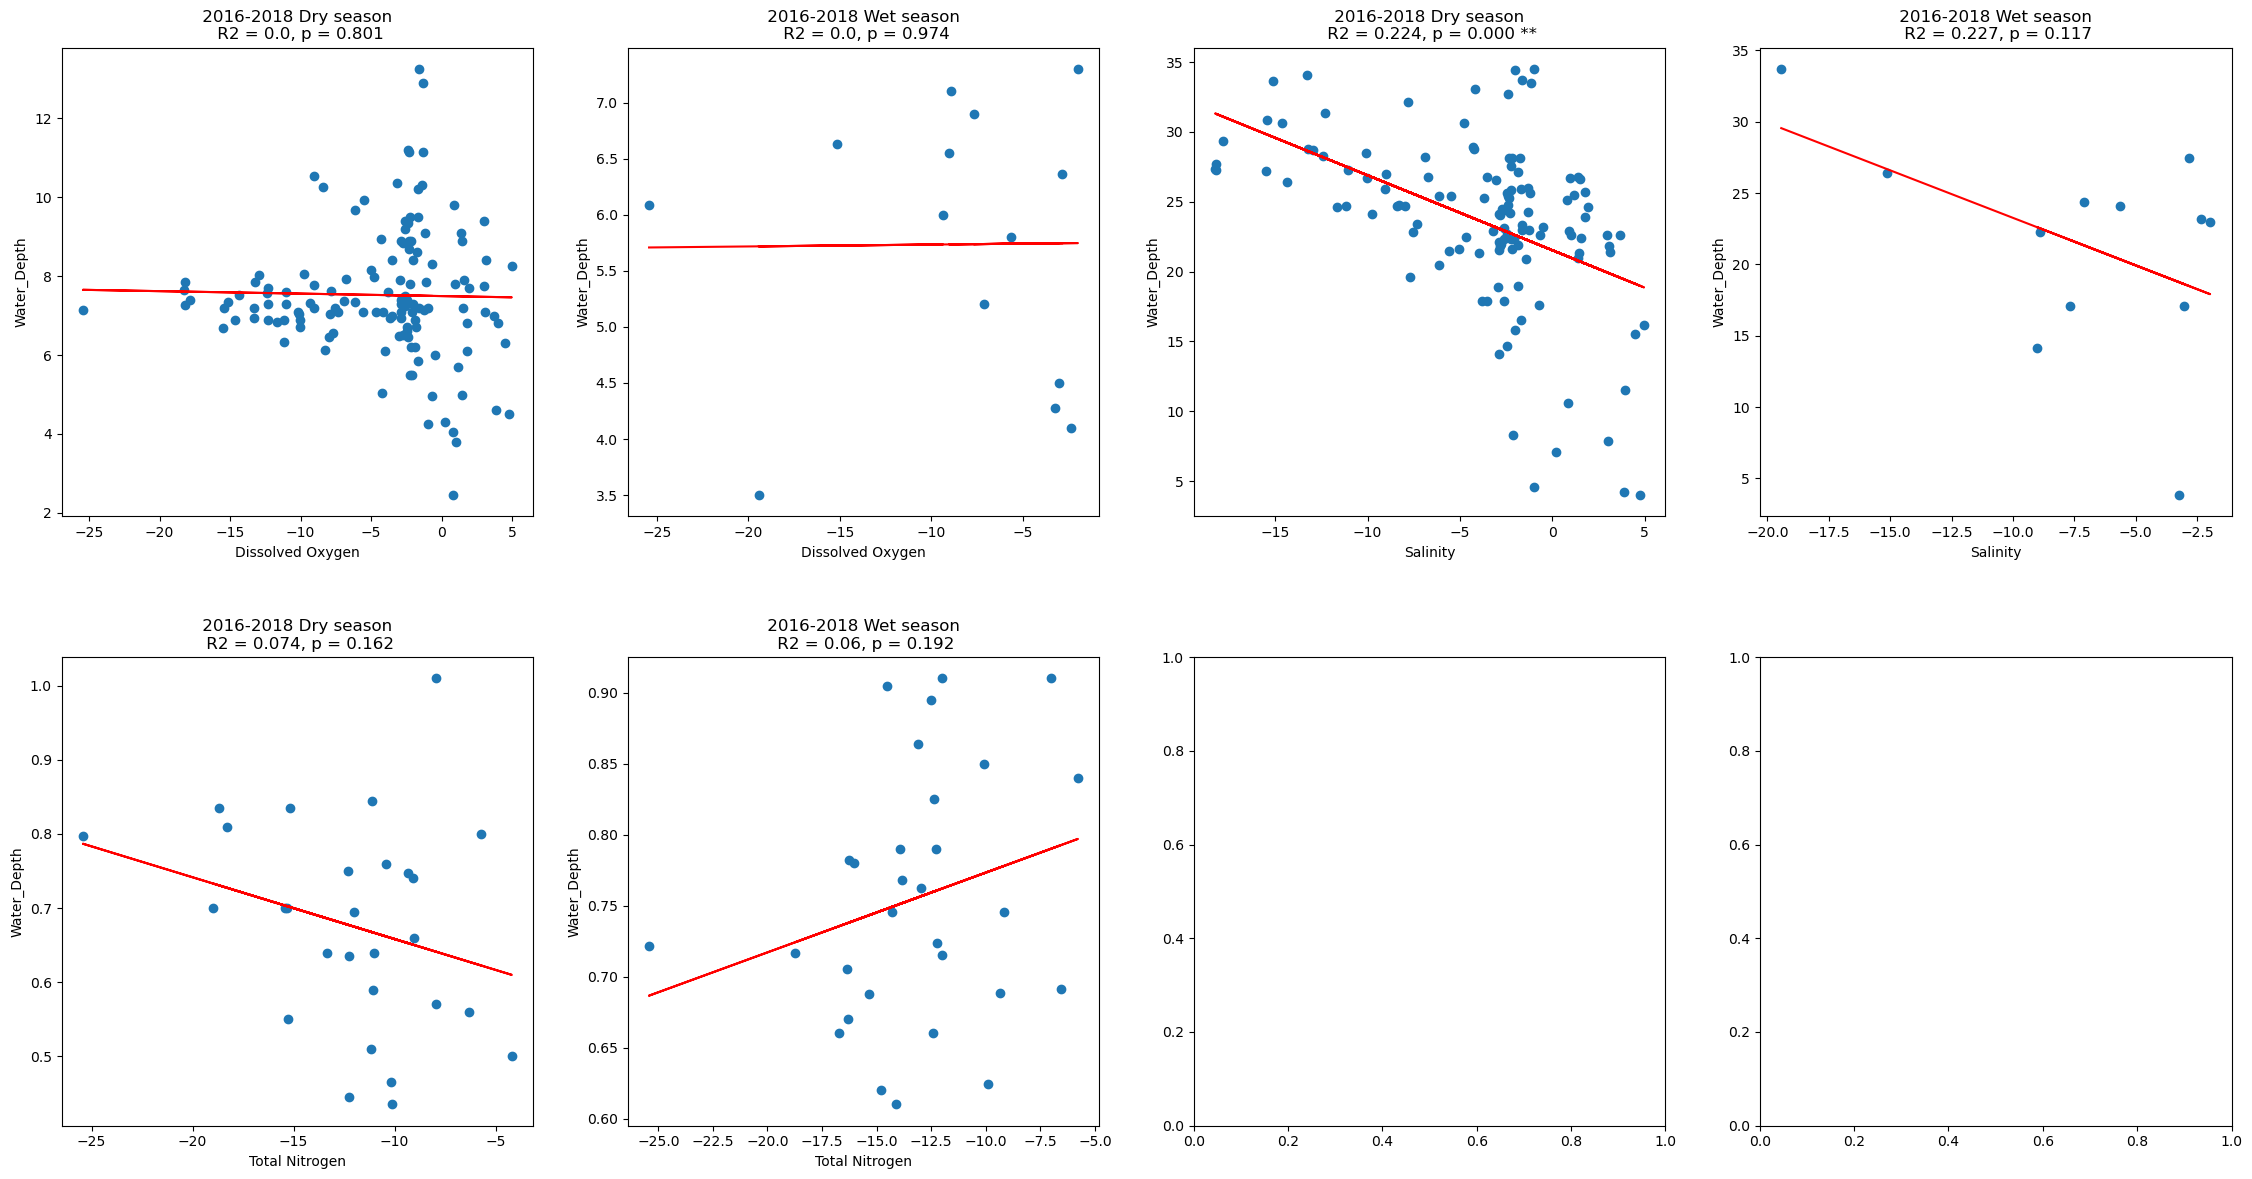

In [249]:
plot_regression(outputs_WD[outputs_WD['Area']=='Charlotte_Harbor'])

### 4.1.2 Land development index (LDI_HUC_LSS) <a class="anchor" id="reg_result_ch_ldi"></a>

In [250]:
results_LDI_HUC_LSS[results_LDI_HUC_LSS['Area'] == 'Charlotte_Harbor']

,Dependent,Independent,Area,Year,Season,Coefficient,R-squared,p-value
1,Dissolved Oxygen,LDI_HUC_LSS,Charlotte_Harbor,2016-2018,Dry,-0.208872,0.152161,0.000 **
4,Dissolved Oxygen,LDI_HUC_LSS,Charlotte_Harbor,2016-2018,Wet,-0.129781,0.072806,0.351
7,Salinity,LDI_HUC_LSS,Charlotte_Harbor,2016-2018,Dry,-1.069257,0.291334,0.000 **
10,Salinity,LDI_HUC_LSS,Charlotte_Harbor,2016-2018,Wet,-1.026040,0.134928,0.240
13,Total Nitrogen,LDI_HUC_LSS,Charlotte_Harbor,2016-2018,Dry,0.024356,0.042010,0.295
16,Total Nitrogen,LDI_HUC_LSS,Charlotte_Harbor,2016-2018,Wet,0.002824,0.001406,0.844


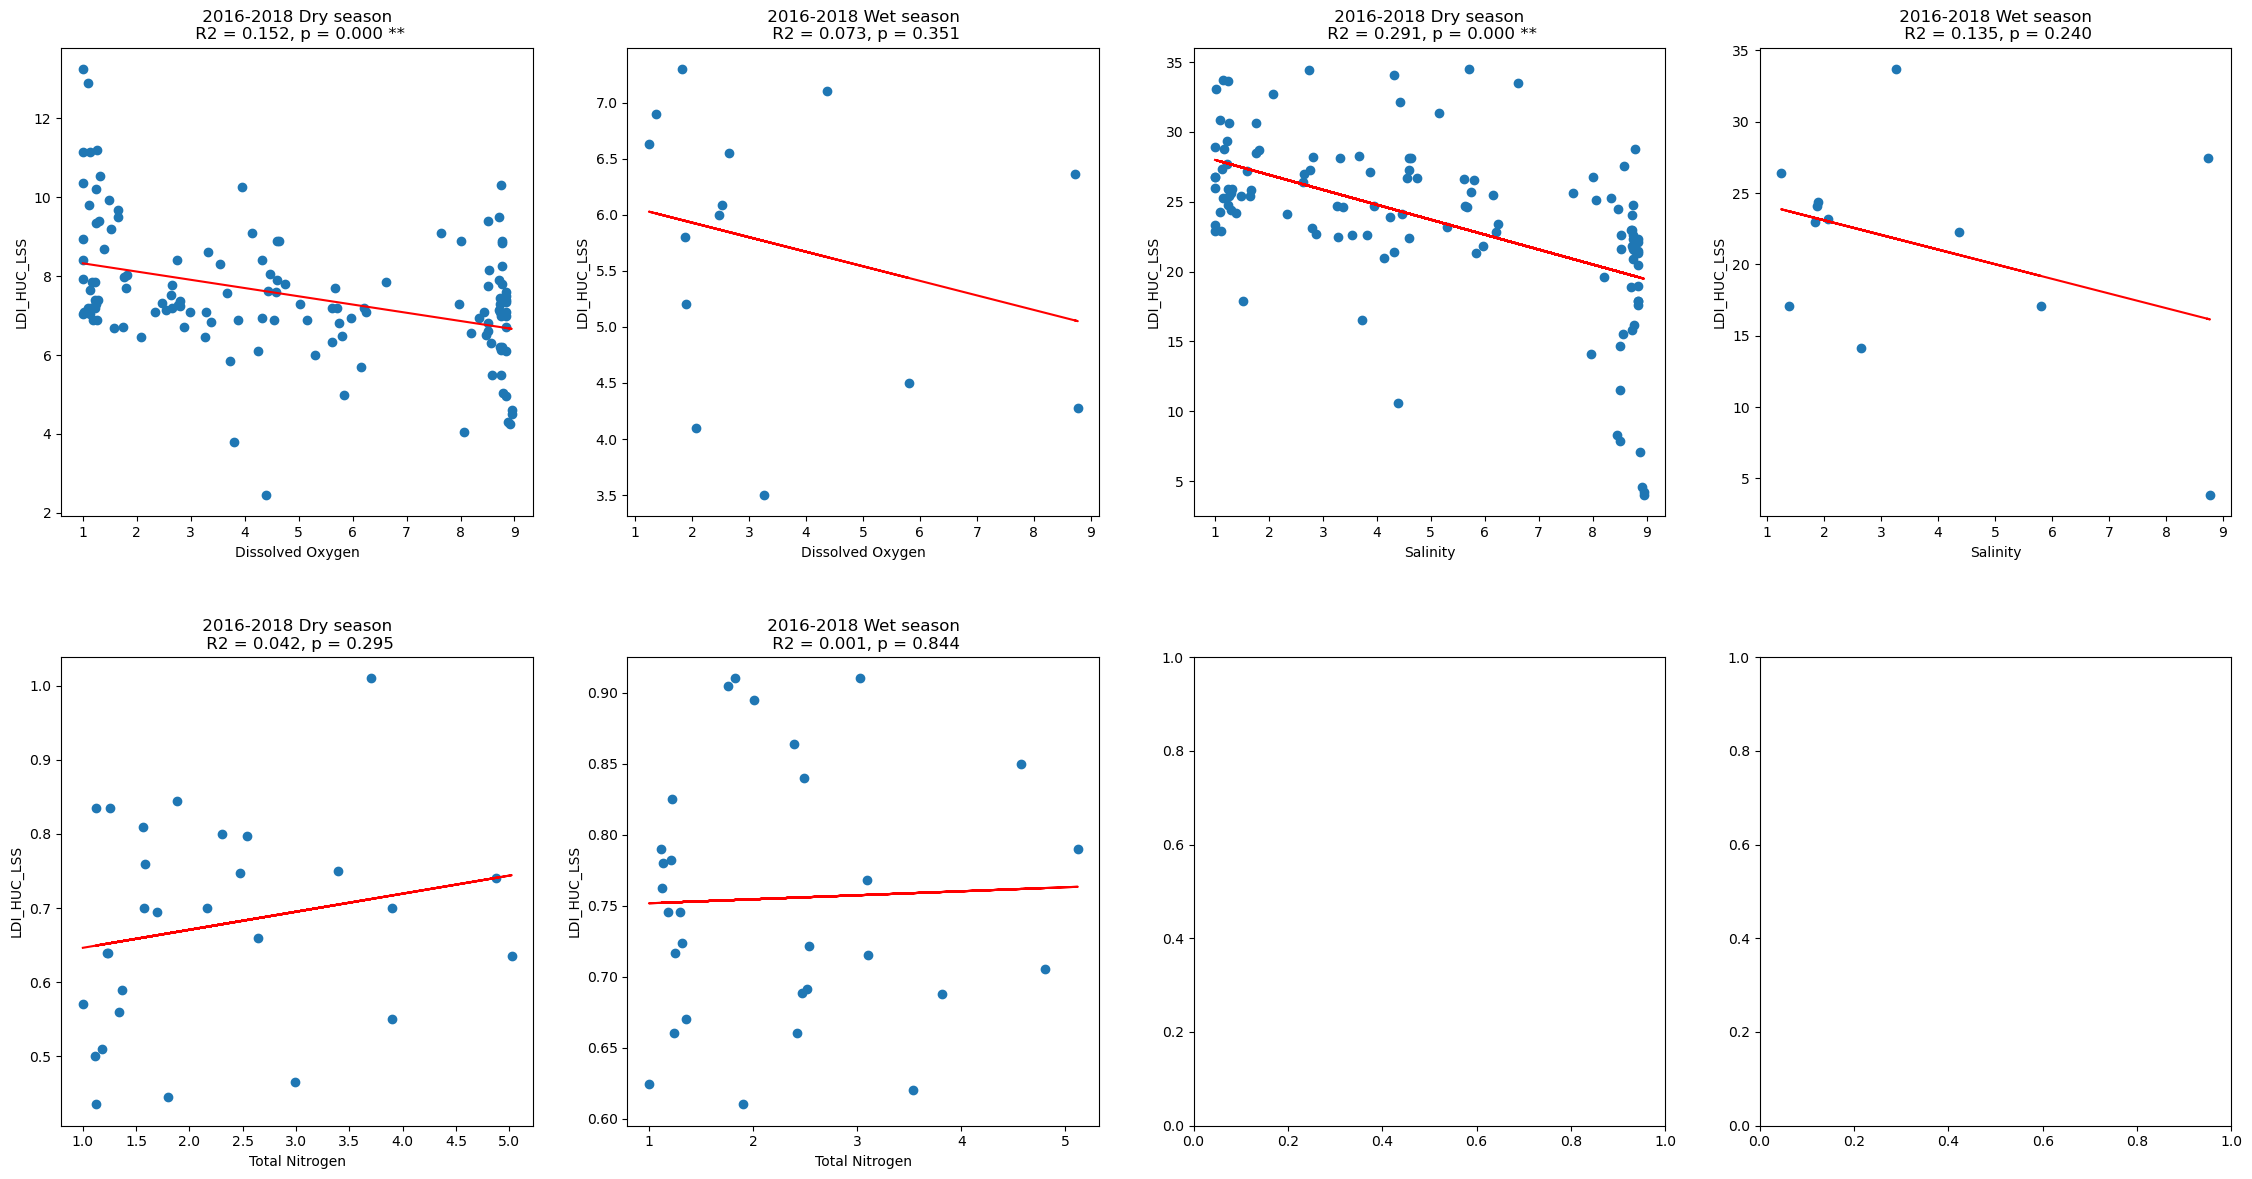

In [251]:
plot_regression(outputs_LDI_HUC_LSS[outputs_LDI_HUC_LSS['Area'] == 'Charlotte_Harbor'])

## 4.2 Estuary Bay <a class="anchor" id="reg_result_eb"></a>
### 4.2.1 Water Quality  <a class="anchor" id="reg_result_eb_wd"></a>

In [252]:
results_WD[results_WD['Area'] == 'Estero_Bay']

,Dependent,Independent,Area,Year,Season,Coefficient,R-squared,p-value
2,Dissolved Oxygen,Water_Depth,Estero_Bay,2016-2018,Dry,-0.055977,0.024776,0.177
5,Dissolved Oxygen,Water_Depth,Estero_Bay,2016-2018,Wet,-0.029644,0.009241,0.516
8,Salinity,Water_Depth,Estero_Bay,2016-2018,Dry,-0.644303,0.231393,0.043 *
11,Salinity,Water_Depth,Estero_Bay,2016-2018,Wet,-1.133508,0.395490,0.038 *
14,Total Nitrogen,Water_Depth,Estero_Bay,2016-2018,Dry,0.002557,0.003646,0.647
17,Total Nitrogen,Water_Depth,Estero_Bay,2016-2018,Wet,0.003223,0.016118,0.435


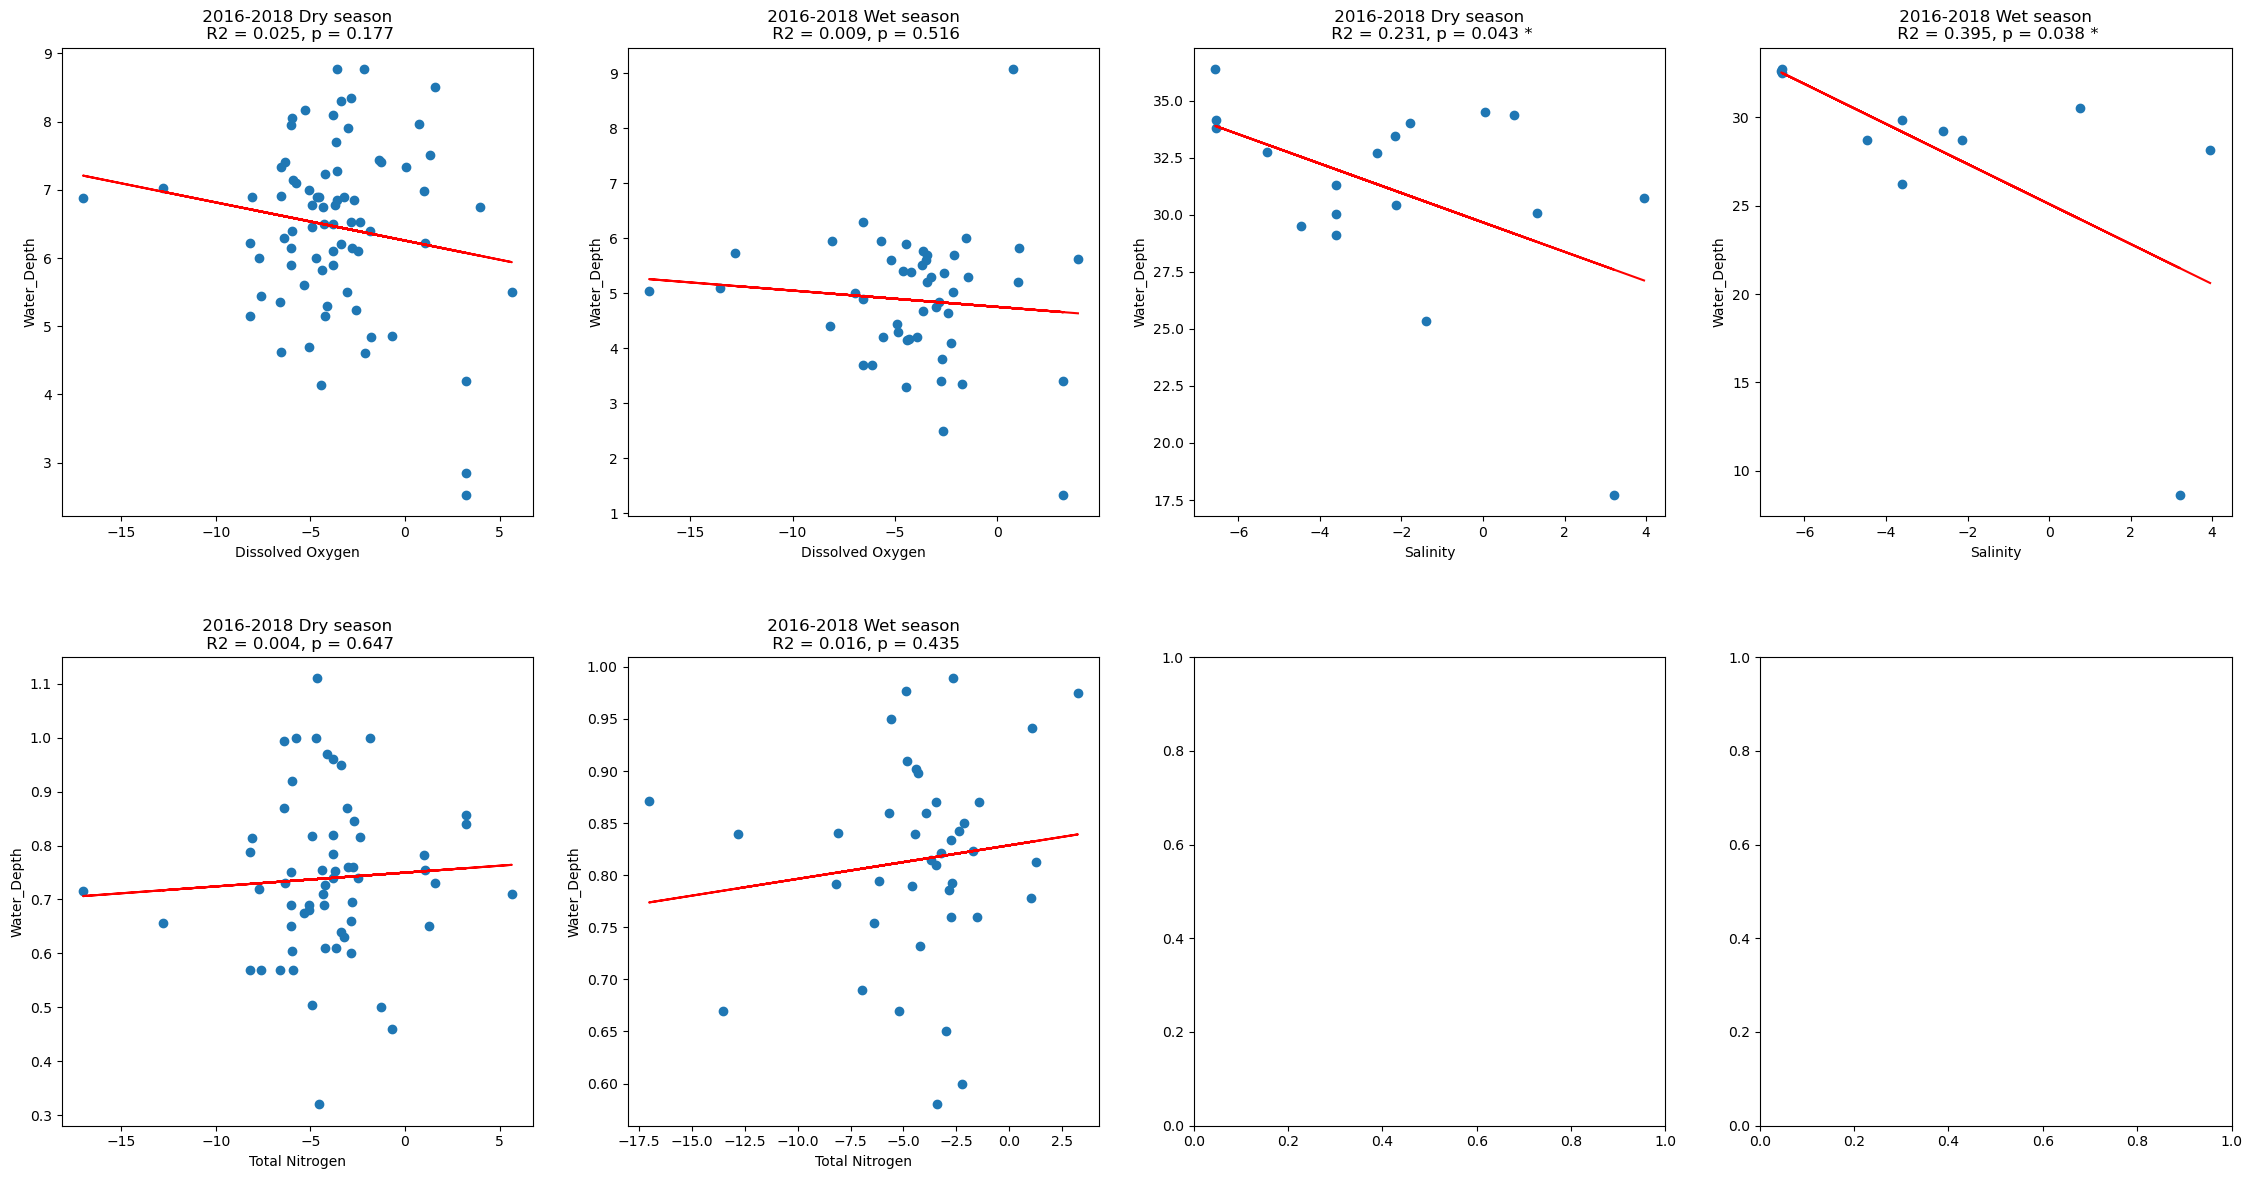

In [253]:
plot_regression(outputs_WD[outputs_WD['Area'] == 'Estero_Bay'])

## 4.2.2 Land development index (LDI_WHO_LSS)  <a class="anchor" id="reg_result_eb_ldi"></a>

In [254]:
results_LDI_WHO_LSS[results_LDI_WHO_LSS['Area'] == 'Estero_Bay']

,Dependent,Independent,Area,Year,Season,Coefficient,R-squared,p-value
2,Dissolved Oxygen,LDI_WHO_LSS,Estero_Bay,2016-2018,Dry,-0.231407,0.056628,0.040 *
5,Dissolved Oxygen,LDI_WHO_LSS,Estero_Bay,2016-2018,Wet,-0.363443,0.170998,0.003 **
8,Salinity,LDI_WHO_LSS,Estero_Bay,2016-2018,Dry,-0.554157,0.047377,0.386
11,Salinity,LDI_WHO_LSS,Estero_Bay,2016-2018,Wet,-2.302377,0.276301,0.097
14,Total Nitrogen,LDI_WHO_LSS,Estero_Bay,2016-2018,Dry,-0.012616,0.011181,0.421
17,Total Nitrogen,LDI_WHO_LSS,Estero_Bay,2016-2018,Wet,0.008619,0.015876,0.438


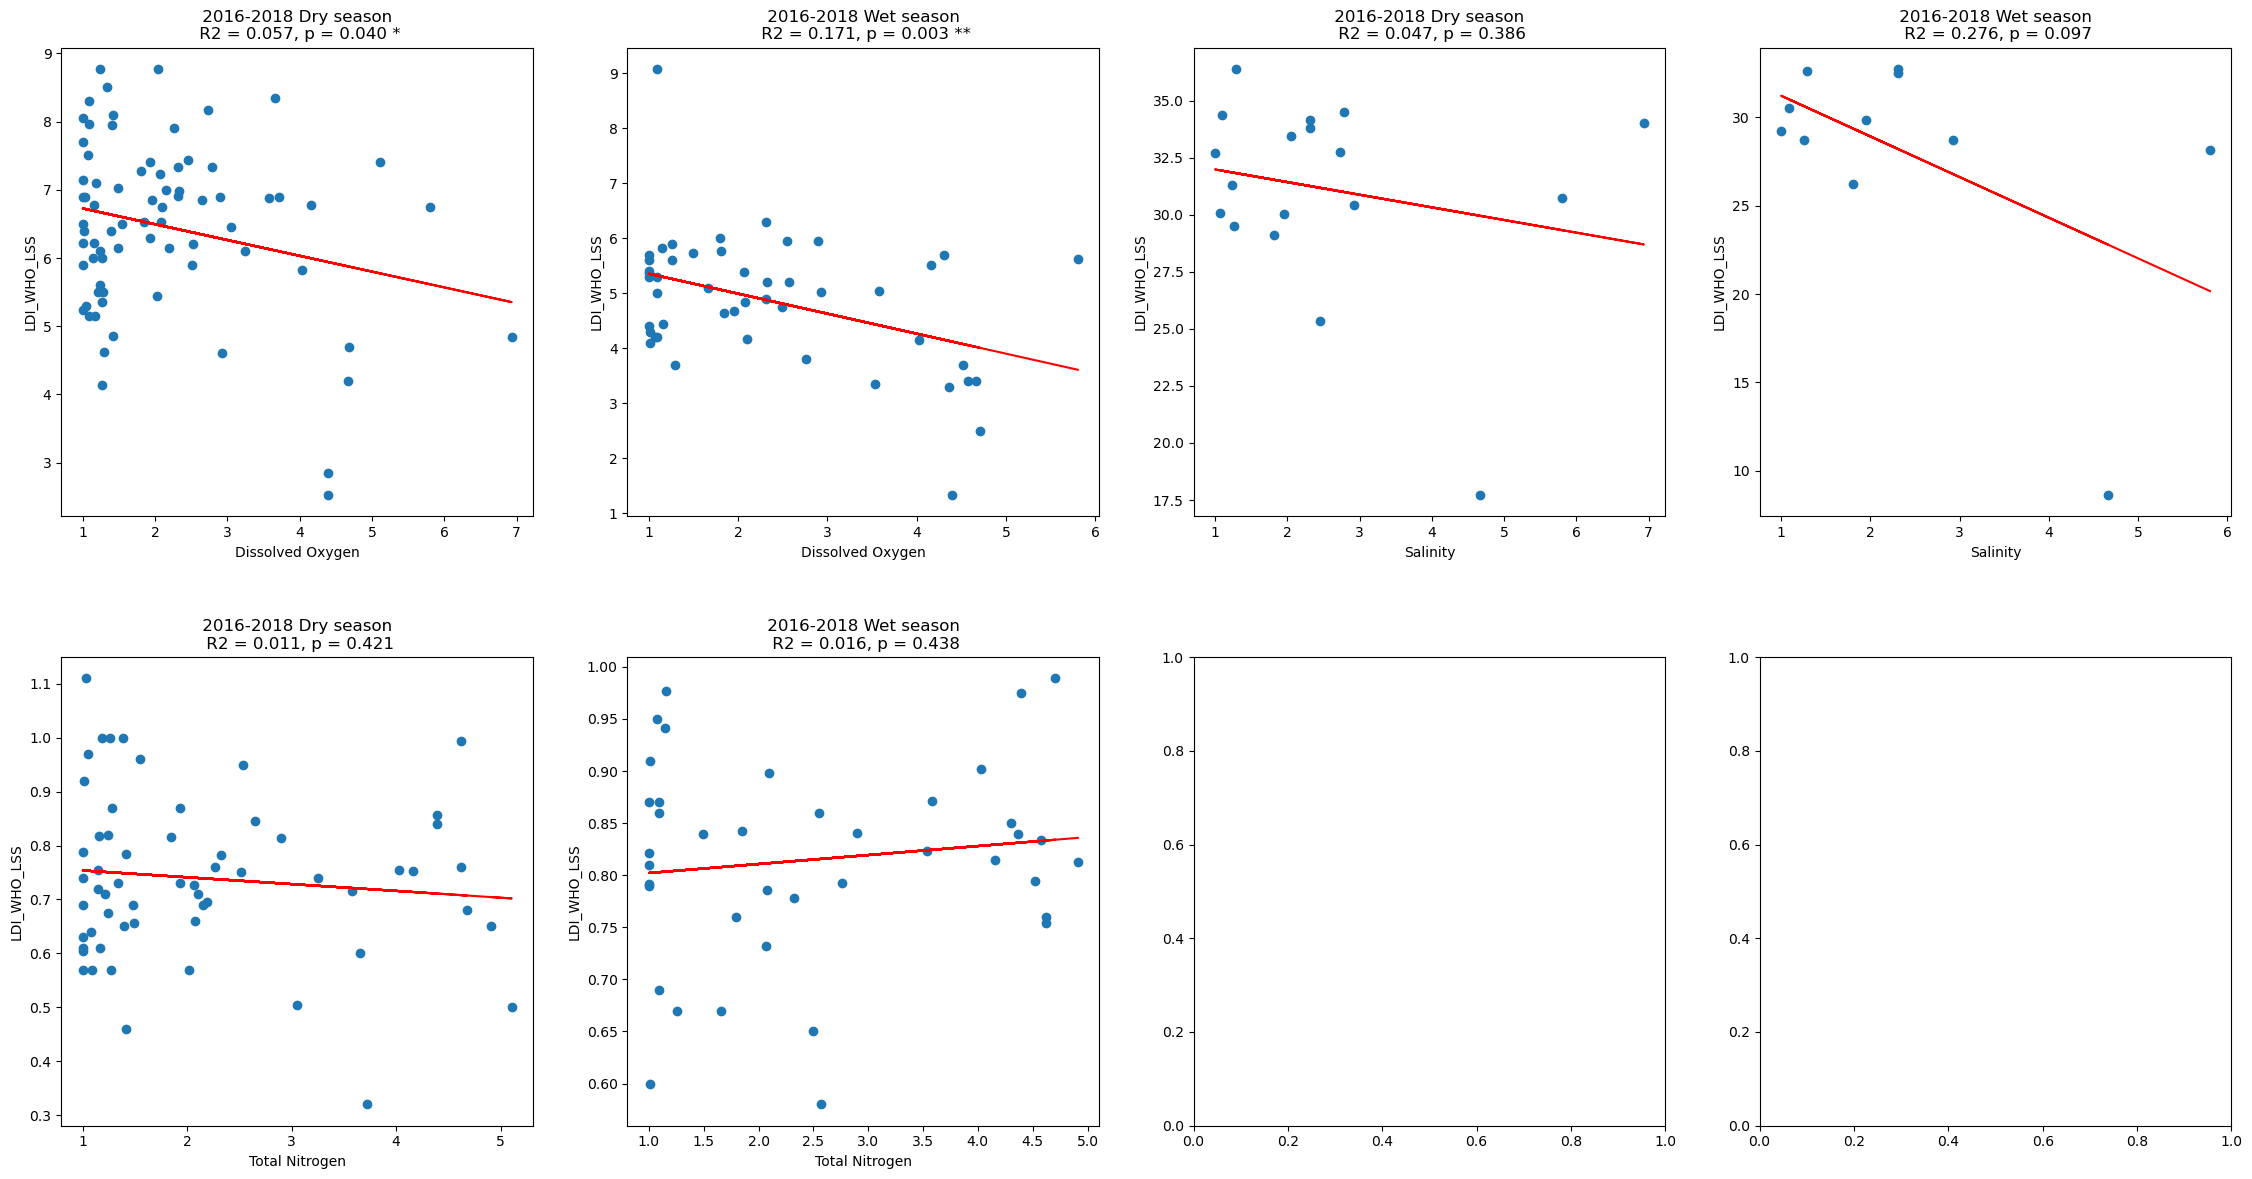

In [255]:
plot_regression(outputs_LDI_WHO_LSS[outputs_LDI_WHO_LSS['Area'] == 'Estero_Bay'])

# 4.3 Big Bend  <a class="anchor" id="reg_result_bb"></a>
## 4.3.1 Water Depth  <a class="anchor" id="reg_result_bb_wd"></a>

In [256]:
results_WD[results_WD['Area'] == 'Big_Bend']

,Dependent,Independent,Area,Year,Season,Coefficient,R-squared,p-value
0,Dissolved Oxygen,Water_Depth,Big_Bend,2016-2018,Dry,-2.387829e-02,0.010368,0.071
3,Dissolved Oxygen,Water_Depth,Big_Bend,2016-2018,Wet,-4.564853e-02,0.062158,0.018 *
6,Salinity,Water_Depth,Big_Bend,2016-2018,Dry,-7.388430e-01,0.160686,0.000 **
9,Salinity,Water_Depth,Big_Bend,2016-2018,Wet,7.517647e-38,-4.952352,0.234
12,Total Nitrogen,Water_Depth,Big_Bend,2016-2018,Dry,8.744912e-03,0.036132,0.142
15,Total Nitrogen,Water_Depth,Big_Bend,2016-2018,Wet,8.122836e-03,0.017124,0.328


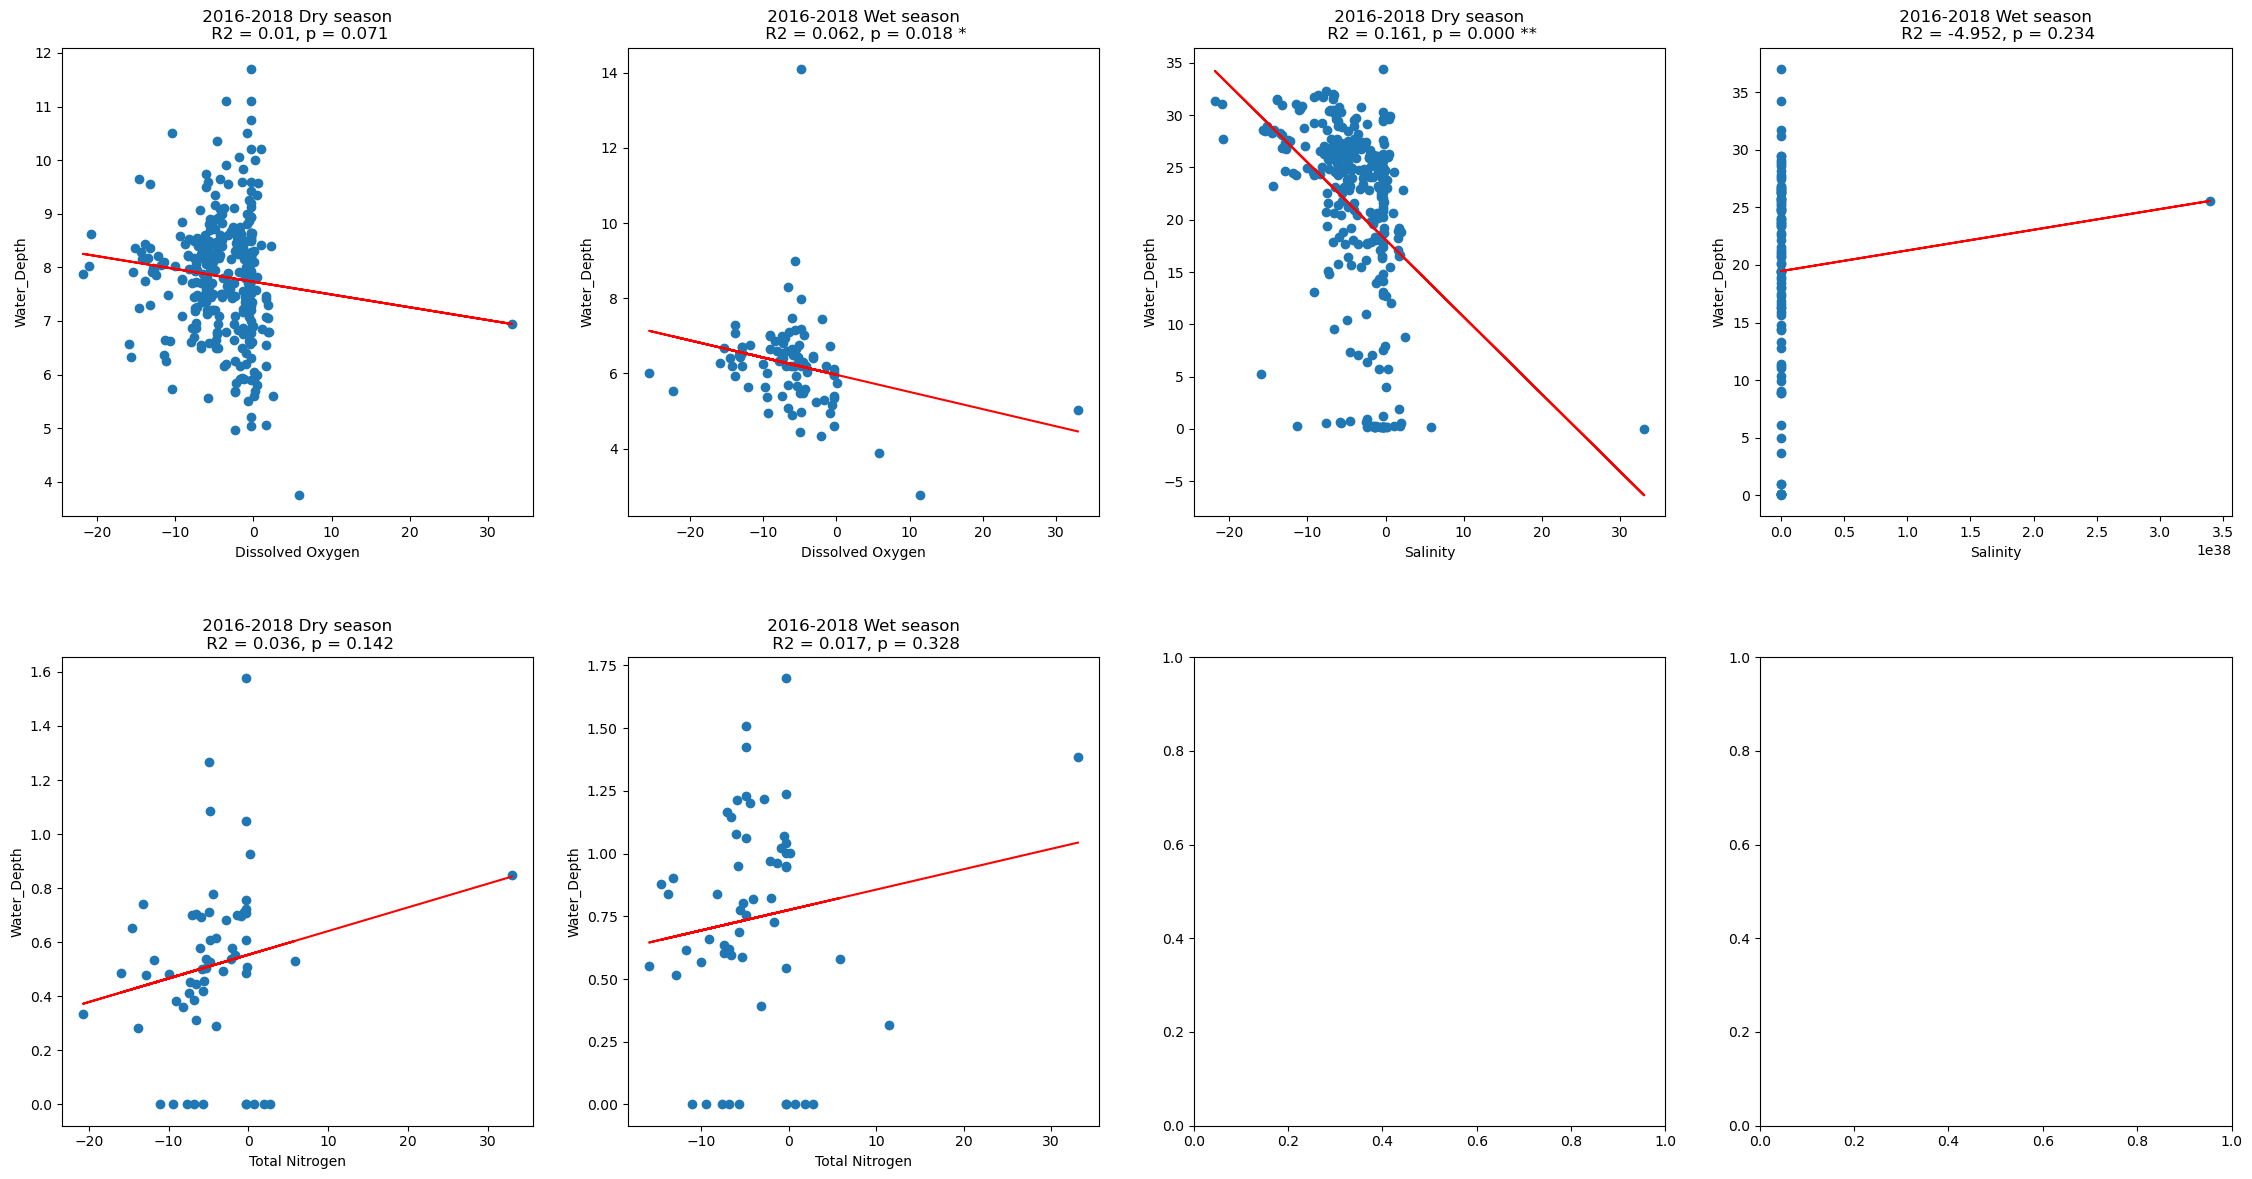

In [257]:
plot_regression(outputs_WD[outputs_WD['Area'] == 'Big_Bend'])

## 4.3.2 Land development index (LDI_WHO_LSS)  <a class="anchor" id="reg_result_bb_ldi"></a>

In [258]:
results_LDI_WHO_LSS[results_LDI_WHO_LSS['Area'] == 'Estero_Bay']

,Dependent,Independent,Area,Year,Season,Coefficient,R-squared,p-value
2,Dissolved Oxygen,LDI_WHO_LSS,Estero_Bay,2016-2018,Dry,-0.231407,0.056628,0.040 *
5,Dissolved Oxygen,LDI_WHO_LSS,Estero_Bay,2016-2018,Wet,-0.363443,0.170998,0.003 **
8,Salinity,LDI_WHO_LSS,Estero_Bay,2016-2018,Dry,-0.554157,0.047377,0.386
11,Salinity,LDI_WHO_LSS,Estero_Bay,2016-2018,Wet,-2.302377,0.276301,0.097
14,Total Nitrogen,LDI_WHO_LSS,Estero_Bay,2016-2018,Dry,-0.012616,0.011181,0.421
17,Total Nitrogen,LDI_WHO_LSS,Estero_Bay,2016-2018,Wet,0.008619,0.015876,0.438


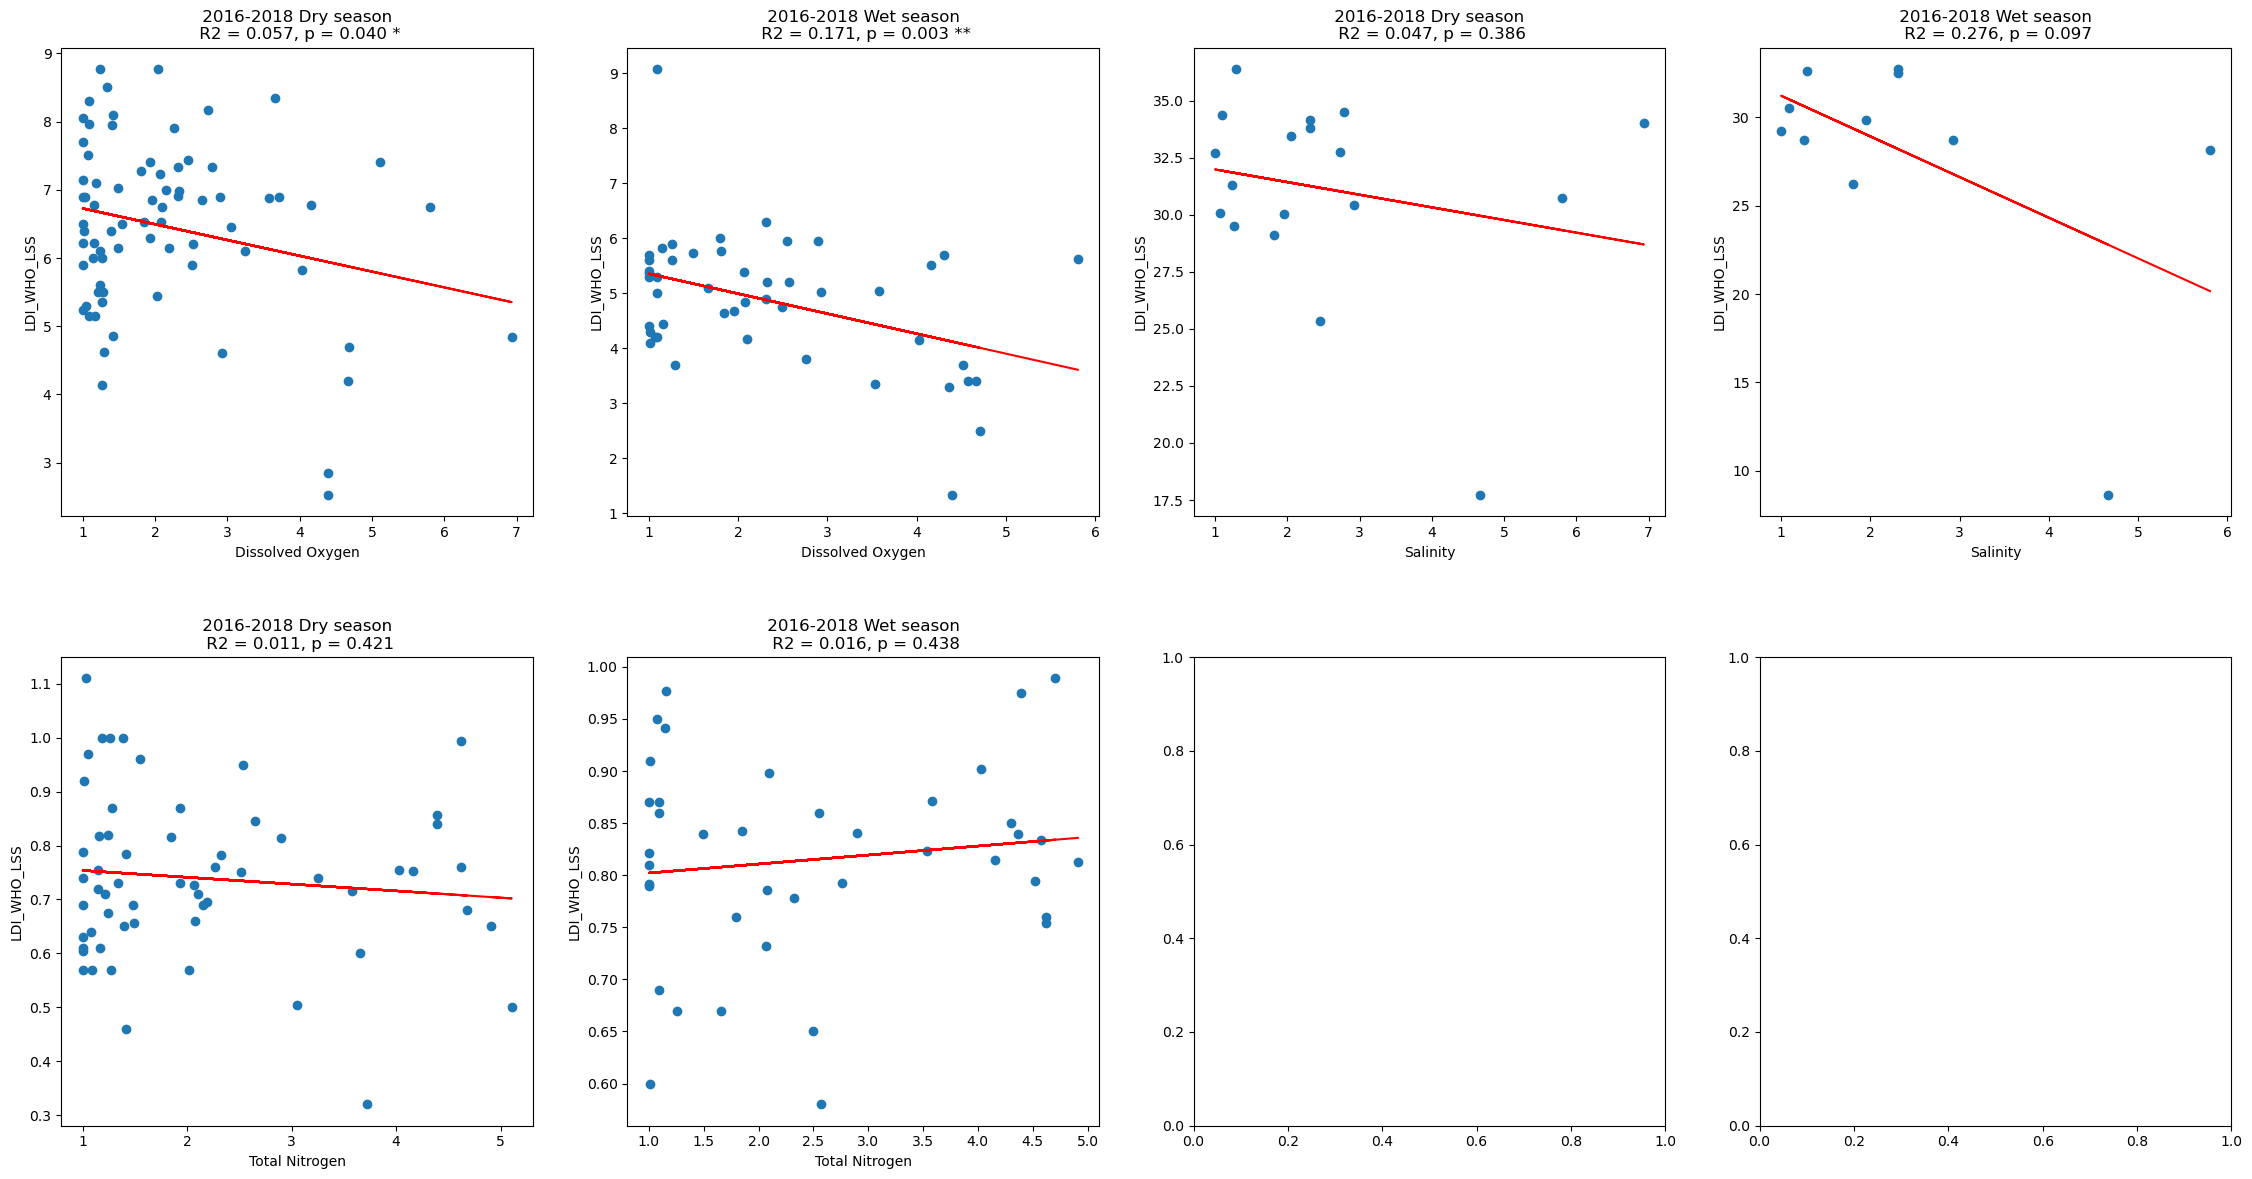

In [259]:
plot_regression(outputs_LDI_WHO_LSS[outputs_LDI_WHO_LSS['Area'] == 'Estero_Bay'])